# A Practice on "MovieLens 100K Dataset": #4: Matrix Factorization with Alternating Least Squares (ALS)

Previously, I showed how to use similarity-based approaches that guess unknown user-movie-rating triplets by looking at either movies with a similar rating profile or users with a similar rating profile. These approaches leave a lot of data on the table though. Matrix factorization is a way to both take into account more data and perform some regularizing dimensionality reduction to help deal with the sparsity problem.

The basic idea is to organize the user-movie-rating triplets into a matrix with each row representing a user and each column representing a movie. We want to approximate this large matrix with a matrix multiplication of 2 smaller matrices. In the example below, each row of the "User Matrix" has 2 latent features of that user, and each column of the "Item Matrix" has 2 latent features of that item. The dot product of any user's latent features and item's latent features will give an estimate of the rating that user would give that movie.

![Matrix Factorization Example](https://github.com/benlindsay/movielens-analysis/blob/master/images/matrix-factorization.png?raw=1)

Image Source: [https://medium.com/@connectwithghosh](https://medium.com/@connectwithghosh/simple-matrix-factorization-example-on-the-movielens-dataset-using-pyspark-9b7e3f567536)

There are many variations on this theme and multiple ways to perform this matrix factorization. The method I demonstrate here is called "Alternating Least Squares" method which was designed for the [Netflix Prize](https://www.netflixprize.com/) and described in [this paper](http://www.grappa.univ-lille3.fr/~mary/cours/stats/centrale/reco/paper/MatrixFactorizationALS.pdf). This method works iteratively, with 2 main steps per iteration:

1. Assume the User Matrix is fixed and solve for the Item Matrix
2. Assume the Item Matrix is fixed and solve for the User Matrix




# 0. Mount and load raw data

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
cd /gdrive/MyDrive/Lectures/2024/RecSys

/gdrive/MyDrive/Lectures/2024/RecSys


# 1. Import necessary modules and classes

In [3]:
# <!-- collapse=True -->
%matplotlib inline
from datetime import datetime
from functools import reduce
from os.path import exists
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

# Import User + Movie baseline model
from cf_utils import DampedUserMovieBaselineModel

# Use custom matplotlib stylesheet
plt.style.use('seaborn-darkgrid')

<ipython-input-3-e72051cea4ab>:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


# 2. Load the Data

Let's load and examine the ratings data. If you're following along (i.e. actually running these notebooks) you'll need to make sure to run the first one to download the data before running this one.

In [4]:
# <!-- collapse=True -->
ratings_df = pd.read_csv('raw/ml-100k/u.data', sep='\t', header=None,
                         names=['userId', 'movieId', 'rating', 'timestamp'])
ratings_df['timestamp'] = ratings_df['timestamp'].apply(datetime.fromtimestamp)
ratings_df = ratings_df.sort_values('timestamp')
print('First 5:')
display(ratings_df.head())
print()
print('Last 5:')
display(ratings_df.tail())

First 5:


,userId,movieId,rating,timestamp
214,259,255,4,1997-09-20 03:05:10
83965,259,286,4,1997-09-20 03:05:27
43027,259,298,4,1997-09-20 03:05:54
21396,259,185,4,1997-09-20 03:06:21
82655,259,173,4,1997-09-20 03:07:23



Last 5:


,userId,movieId,rating,timestamp
46773,729,689,4,1998-04-22 23:10:38
73008,729,313,3,1998-04-22 23:10:38
46574,729,328,3,1998-04-22 23:10:38
64312,729,748,4,1998-04-22 23:10:38
79208,729,272,4,1998-04-22 23:10:38


# 3. Write helper function and ALSRecommender class

In [5]:
# <!-- collapse=True -->
def get_rating_matrix(X):
    """Function to generate a ratings matrx and mappings for
    the user and item ids to the row and column indices

    Parameters
    ----------
    X : pandas.DataFrame, shape=(n_ratings,>=3)
        First 3 columns must be in order of user, item, rating.

    Returns
    -------
    rating_matrix : 2d numpy array, shape=(n_users, n_items)
    user_map : pandas Series, shape=(n_users,)
        Mapping from the original user id to an integer in the range [0,n_users)
    item_map : pandas Series, shape=(n_items,)
        Mapping from the original item id to an integer in the range [0,n_items)
    """
    user_col, item_col, rating_col = X.columns[:3]
    rating = X[rating_col]
    user_map = pd.Series(
        index=np.unique(X[user_col]),
        data=np.arange(X[user_col].nunique()),
        name='user_map',
    )
    item_map = pd.Series(
        index=np.unique(X[item_col]),
        data=np.arange(X[item_col].nunique()),
        name='columns_map',
    )
    user_inds = X[user_col].map(user_map)
    item_inds = X[item_col].map(item_map)
    rating_matrix = (
        pd.pivot_table(
            data=X,
            values=rating_col,
            index=user_inds,
            columns=item_inds,
        )
        .fillna(0)
        .values
    )
    return rating_matrix, user_map, item_map

In [6]:
a,b,c = get_rating_matrix(ratings_df)

In [7]:
a.shape

(943, 1682)

In [8]:
for i, Ri in enumerate(a):
  print(i, Ri, Ri.shape)
  print( np.nonzero(Ri) )
  break

0 [5. 3. 4. ... 0. 0. 0.] (1682,)
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 17

In [9]:
V = np.ones((5,2))

In [10]:
V_Ri = V[[1,2,3,4],:]
Ri_nonzero=np.array([1,2,3,4])

In [11]:
V_Ri.shape, Ri_nonzero.shape

((4, 2), (4,))

In [12]:
Ri_nonzero @ V_Ri, np.dot(Ri_nonzero, V_Ri)

(array([10., 10.]), array([10., 10.]))

In [14]:
# <!-- collapse=True -->
class ALSRecommender():
    """Recommender based on Alternating Least Squares algorithm.

    Parameters
    ----------
    k : int, default=5
        Number of latent features
    lmbda : float, default=0.1
        Regularization parameter
    max_epochs : int, default=15
        Max number of iterations to run
    baseline_algo : object
        Object with fit(X) and
    """
    def __init__(self, k=5, lmbda=0.1, max_epochs=15, baseline_algo=None, error_metric='mae',
                 verbose=True):
        # Force integer in case it comes in as float
        self.k = int(np.round(k))
        self.lmbda = lmbda
        self.max_epochs = max_epochs
        self.baseline_algo = baseline_algo
        self.error_metric = error_metric
        self.verbose = verbose

        self.U = None
        self.V = None
        self.initialized = False

    def _calc_train_error(self, U, V, R, R_selector=None, error_metric='mae'):
        if R_selector is None:
            R_selector = (R > 0)
        R_hat = U @ V.T
        if error_metric == 'mae':
            error = np.sum(R_selector * np.abs(R_hat - R)) / np.sum(R_selector)
        else:
            raise ValueError("{} is an unsupported error metric".format(error_metric))
        return error

    def _fit_init(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a DataFrame")
        X = X.copy()
        user_col, item_col, rating_col = X.columns[:3]
        if self.baseline_algo is None:
            self.train_mean = X[rating_col].mean()
        else:
            self.baseline_algo.fit(X)
        self.R, self.user_map, self.item_map = get_rating_matrix(X)
        n_users, n_items = self.R.shape
        # self.U = 3 * np.random.rand(self.k, size=(n_users, self.k))
        # self.V = 3 * np.random.rand(self.k, size=(n_items, self.k))
        self.U = 3*np.random.rand(n_users, self.k)
        self.V = 3*np.random.rand(n_items, self.k)
        self.V[:, 0] = self.R[self.R != 0].mean(axis=0) # Avg. rating for each movie
        self.E = np.eye(self.k) # (k x k)-dimensional idendity matrix
        self.epoch = 0
        self.train_errors = []
        self.initialized = True

    def fit(self, X, n_epochs=None):
        """Fit model to training data X. If at least one iteration has already been run,
        then the model will continue from its most recent state.

        Parameters
        ----------
        X : pandas DataFrame, shape=(n_ratings, >=3)
            First 3 columns must correspond to user, item, and rating in that order
        n_epochs : int, optional
            Number of iterations to run. If not provided, will run for self.max_epochs

        Returns
        -------
        self
            This allows chaining like `ALSRecommender().fit(X_train).predict(X_test)`
        """
        # Allow continuation from previous state if n_epochs is given. Otherwise start from scratch.
        if n_epochs is None:
            self.initialized = False
        if not self.initialized:
            self._fit_init(X)

        epoch_0 = self.epoch
        if n_epochs is None:
            n_epochs = self.max_epochs - epoch_0

        n_users, n_items = self.R.shape

        # Run n_epochs iterations
        for i_epoch in range(n_epochs):
            if self.epoch >= self.max_epochs:
                print("max_epochs = {}".format(self.max_epochs))
                break
            # Fix V and estimate U
            for i, Ri in enumerate(self.R):
                nui = np.count_nonzero(Ri) # Number of items user i has rated
                if (nui == 0): nui = 1 # Be aware of zero counts!
                # Get array of nonzero indices in row Ii
                Ri_nonzero_selector = np.nonzero(Ri)[0]
                # Select subset of V associated with movies reviewed by user i
                V_Ri = self.V[Ri_nonzero_selector, :] # shape=(n', k)
                # Select subset of row R_i associated with movies reviewed by user i
                Ri_nonzero = self.R[i, Ri_nonzero_selector] # shape=(n', )
                Ai = V_Ri.T @ V_Ri + self.lmbda * nui * self.E # shape=(k, k)
                # print('nui', nui, end='')
                Vi = Ri_nonzero @ V_Ri # shape=(k, )
                # print('UU', Ai.shape, Vi.shape)
                self.U[i, :] = np.linalg.solve(Ai, Vi)
            # Fix U and estimate V
            for j, Rj in enumerate(self.R.T):
                nmj = np.count_nonzero(Rj) # Number of users that rated item j
                if (nmj == 0): nmj = 1 # Be aware of zero counts!
                # Get array of nonzero indices in row Ij
                Rj_nonzero_selector = np.nonzero(Rj)[0]
                # Select subset of P associated with users who reviewed movie j
                U_Rj = self.U[Rj_nonzero_selector, :] # shape=(m', k)
                # Select subset of column R_j associated with users who reviewed movie j
                Rj_nonzero = self.R[Rj_nonzero_selector, j] # shape=(m', )
                Aj = U_Rj.T @ U_Rj + self.lmbda * nmj * self.E
                # print('nmj', nmj, Rj_nonzero.shape, end='')
                Uj = Rj_nonzero @ U_Rj
                # print('VV', Aj.shape, Uj.shape)
                self.V[j, :] = np.linalg.solve(Aj, Uj)
            error = self._calc_train_error(self.U, self.V, self.R)
            self.train_errors.append(error)
            if self.verbose:
                print("[Epoch {}/{}] train error: {}".format(self.epoch, self.max_epochs, error))
            self.epoch += 1
        return self

    def predict(self, X):
        """Generate predictions for user/item pairs

        Parameters
        ----------
        X : pandas dataframe, shape = (n_pairs, 2)
            User, item dataframe

        Returns
        -------
        rating_pred : 1d numpy array, shape = (n_pairs,)
            Array of rating predictions for each user/item pair
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a DataFrame")
        X = X.copy()
        user_col, item_col = X.columns[:2]
        if self.baseline_algo is None:
            X['rating_baseline'] = self.train_mean
        else:
            X['rating_baseline'] = self.baseline_algo.predict(X)
        X['rating'] = 0
        known_user_and_item_mask = (
            X[user_col].isin(self.user_map.index) & X[item_col].isin(self.item_map.index)
        )
        X_known, X_unknown = X[known_user_and_item_mask], X[~known_user_and_item_mask]
        user_inds = X_known[user_col].map(self.user_map)
        item_inds = X_known[item_col].map(self.item_map)
        rating_pred = np.array([
            np.sum(self.U[u_ind, :] * self.V[i_ind, :])
            for u_ind, i_ind in zip(user_inds, item_inds)
        ])
        X.loc[known_user_and_item_mask, 'rating'] = rating_pred
        X.loc[~known_user_and_item_mask, 'rating'] = self.baseline_algo.predict(X_unknown)
        min_rating = np.min(self.R[np.nonzero(self.R)])
        max_rating = np.max(self.R)
        X.loc[X['rating'] < min_rating, 'rating'] = min_rating
        X.loc[X['rating'] > max_rating, 'rating'] = max_rating
        return X['rating'].values

# 4. Determine how many epochs are necessary

In [15]:
# <!-- collapse=True -->
# %%time
n_splits = 5
max_epochs = 50
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
train_errs = np.zeros((n_splits, max_epochs))
test_errs = np.zeros((n_splits, max_epochs))
for i_fold, (train_inds, test_inds) in enumerate(kf.split(ratings_df)):
    print("i_fold={}".format(i_fold))
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    # train_df, test_df = ratings_df, ratings_df
    baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
    rec = ALSRecommender(k=20, baseline_algo=baseline_algo, verbose=False, max_epochs=max_epochs)
    for i_epoch in range(max_epochs):
        rec.fit(train_df, n_epochs=1)
        preds = rec.predict(test_df[['userId', 'movieId']])
        test_err = mean_absolute_error(preds, test_df['rating'])
        print("[Epoch {}/{}] test MAE: {}".format(i_epoch, max_epochs, test_err))
        # break
        test_errs[i_fold, i_epoch] = test_err
    train_errs[i_fold, :] = np.array(rec.train_errors)
    # break

print(f"There are {len(rec.user_map)} users and {len(rec.item_map)} items")

i_fold=0
[Epoch 0/50] test MAE: 1.0398034833386356
[Epoch 1/50] test MAE: 0.8550790106821341
[Epoch 2/50] test MAE: 0.8102764667879097
[Epoch 3/50] test MAE: 0.7867580909891233
[Epoch 4/50] test MAE: 0.7720571860563153
[Epoch 5/50] test MAE: 0.7622216178554773
[Epoch 6/50] test MAE: 0.7552625086523239
[Epoch 7/50] test MAE: 0.7501381867557136
[Epoch 8/50] test MAE: 0.746185990807431
[Epoch 9/50] test MAE: 0.7430870505366794
[Epoch 10/50] test MAE: 0.7406369711361361
[Epoch 11/50] test MAE: 0.7387166104638473
[Epoch 12/50] test MAE: 0.7371530015775627
[Epoch 13/50] test MAE: 0.7358709993577358
[Epoch 14/50] test MAE: 0.7348268350381125
[Epoch 15/50] test MAE: 0.7339626603339808
[Epoch 16/50] test MAE: 0.7332366134098828
[Epoch 17/50] test MAE: 0.7326149003148774
[Epoch 18/50] test MAE: 0.7320747857962253
[Epoch 19/50] test MAE: 0.7316185863661568
[Epoch 20/50] test MAE: 0.7312144629223345
[Epoch 21/50] test MAE: 0.7308614772203624
[Epoch 22/50] test MAE: 0.7305464905943478
[Epoch 23/50]

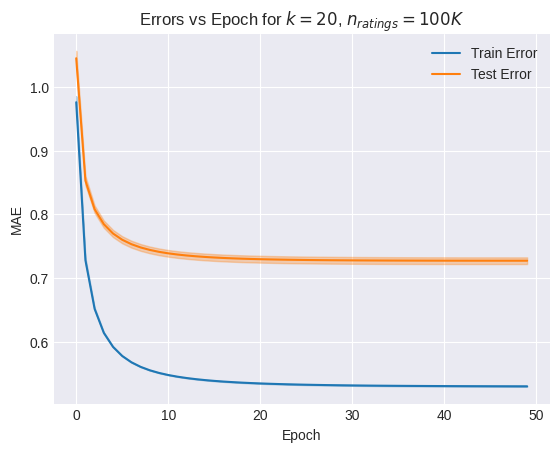

In [16]:
train_avg, train_std = train_errs.mean(axis=0), train_errs.std(axis=0)
test_avg, test_std = test_errs.mean(axis=0), test_errs.std(axis=0)
l, = plt.plot(np.arange(max_epochs), train_avg, label='Train Error')
plt.fill_between(np.arange(max_epochs), train_avg-train_std, train_avg+train_std,
                 color=l.get_color(), alpha=0.3)
l, = plt.plot(np.arange(max_epochs), test_avg, label='Test Error')
plt.fill_between(np.arange(max_epochs), test_avg-test_std, test_avg+test_std,
                 color=l.get_color(), alpha=0.3)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title(r'Errors vs Epoch for $k=20$, $n_{ratings}=100K$')
plt.show()

15 or 20 epochs seems like enough for Test Error to start plateauing.

# 5. Find Optimal $k$

In [17]:
n_splits = 5
max_epochs = 15
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
k_list = [1, 2, 5, 10, 20, 50, 100]
small_df = ratings_df.iloc[:100000]
train_errs = np.zeros((n_splits, len(k_list)))
test_errs = np.zeros((n_splits, len(k_list)))
for i_fold, (train_inds, test_inds) in enumerate(kf.split(small_df)):
    print("i_fold={}: ".format(i_fold), end='')
    train_df, test_df = small_df.iloc[train_inds], small_df.iloc[test_inds]
    baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
    for i_k, k in enumerate(k_list):
        print("k={}, ".format(k), end='')
        rec = ALSRecommender(k=k, baseline_algo=baseline_algo, verbose=False, max_epochs=max_epochs)
        rec.fit(train_df)
        preds = rec.predict(test_df[['userId', 'movieId']])
        test_err = mean_absolute_error(preds, test_df['rating'])
        test_errs[i_fold, i_k] = test_err
        train_errs[i_fold, i_k] = rec.train_errors[-1]
    print()

i_fold=0: k=1, k=2, k=5, k=10, k=20, k=50, k=100, 
i_fold=1: k=1, k=2, k=5, k=10, k=20, k=50, k=100, 
i_fold=2: k=1, k=2, k=5, k=10, k=20, k=50, k=100, 
i_fold=3: k=1, k=2, k=5, k=10, k=20, k=50, k=100, 
i_fold=4: k=1, k=2, k=5, k=10, k=20, k=50, k=100, 


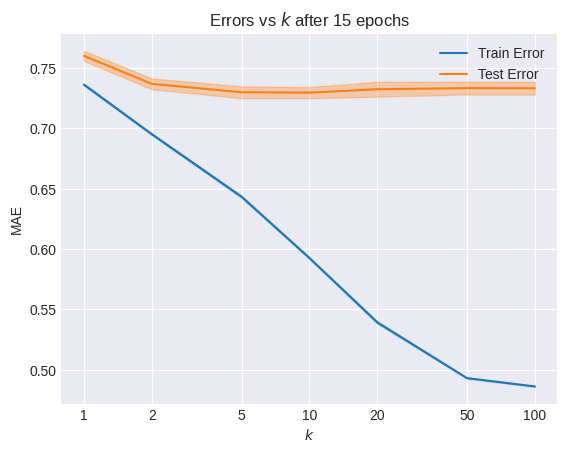

In [18]:
train_avg, train_std = train_errs.mean(axis=0), train_errs.std(axis=0)
test_avg, test_std = test_errs.mean(axis=0), test_errs.std(axis=0)
l, = plt.semilogx(k_list, train_avg, label='Train Error')
plt.fill_between(k_list, train_avg-train_std, train_avg+train_std,
                 color=l.get_color(), alpha=0.3)
l, = plt.semilogx(k_list, test_avg, label='Test Error')
plt.fill_between(k_list, test_avg-test_std, test_avg+test_std,
                 color=l.get_color(), alpha=0.3)
plt.xticks(k_list, k_list)
plt.legend()
plt.xlabel(r'$k$')
plt.ylabel('MAE')
plt.title(r'Errors vs $k$ after {} epochs'.format(max_epochs))
plt.show()

It looks like we have a Test Error minimum around $k=10$, although since $k=5$ is so close, I would go with that since it is likely to generalize better.

Check out the next notebook where I explore Stochastic Gradient Descent!

# Explore Results: Item Matrix

In [19]:
train_df = pd.read_csv('raw/ml-100k/u1.base', sep='\t', header=None,
                         names=['userId', 'movieId', 'rating', 'timestamp'])
train_df['timestamp'] = train_df['timestamp'].apply(datetime.fromtimestamp)
train_df = train_df.sort_values('timestamp')
test_df = pd.read_csv('raw/ml-100k/u1.test', sep='\t', header=None,
                         names=['userId', 'movieId', 'rating', 'timestamp'])
test_df['timestamp'] = test_df['timestamp'].apply(datetime.fromtimestamp)
test_df = test_df.sort_values('timestamp')

In [20]:
baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
rec = ALSRecommender(k=10, baseline_algo=baseline_algo, verbose=False, max_epochs=15)
rec.fit(train_df)
preds = rec.predict(test_df[['userId', 'movieId']])
test_err = mean_absolute_error(preds, test_df['rating'])

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

In [22]:
item_similarity_matrix = cosine_similarity(rec.V)
np.fill_diagonal(item_similarity_matrix, -1)
knn_indices = np.argsort(item_similarity_matrix, axis=1)[:, ::-1][:, :10]
sample_range = np.arange(len(knn_indices))[:, None]
knn_similarities = item_similarity_matrix[sample_range, knn_indices]

In [ ]:
itemidx_to_itemno = pd.Series(rec.item_map.index, index=rec.item_map.values)

In [ ]:
item_info_df = pd.read_csv('raw/ml-100k/u.item', encoding_errors='replace', sep='|', header=None)[[0,1,2]]
item_info_df.columns = ['item_no', 'title', 'release_dt']
itemno_info_df = item_info_df.set_index('item_no')

In [ ]:
itemno_info_df.loc[[itemidx_to_itemno[i]] + list(itemidx_to_itemno[knn_indices[i]])]

,title,release_dt
item_no,,
227,Star Trek VI: The Undiscovered Country (1991),01-Jan-1991
230,Star Trek IV: The Voyage Home (1986),01-Jan-1986
229,Star Trek III: The Search for Spock (1984),01-Jan-1984
380,Star Trek: Generations (1994),01-Jan-1994
222,Star Trek: First Contact (1996),22-Nov-1996
228,Star Trek: The Wrath of Khan (1982),01-Jan-1982
31,Crimson Tide (1995),01-Jan-1995
2,GoldenEye (1995),01-Jan-1995
164,"Abyss, The (1989)",01-Jan-1989
